## Double-Bracket Iteration diagonalization algorithm

In this example we present the `Qibo`'s implementation of the Double-Bracket Iteration (DBI) algorithm, which can be used to prepare the eigenstates of a quantum system. 

#### The initial setup

At first we import some useful packages.

In [2]:
# uncomment this line if seaborn is not installed
# !python -m pip install seaborn

In [3]:
from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from hyperopt import hp, tpe

from qibo import hamiltonians, set_backend
from qibo.models.dbi.double_bracket import DoubleBracketGeneratorType, DoubleBracketIteration, DoubleBracketScheduling

Here we define a simple plotting function useful to keep track of the diagonalization process.

In [4]:
def visualize_matrix(matrix, title=""):
    """Visualize hamiltonian in a heatmap form."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    try:
        im = ax.imshow(np.absolute(matrix), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute(matrix.get()), cmap="inferno")
    fig.colorbar(im, ax=ax)

def visualize_drift(h0, h):
    """Visualize drift of the evolved hamiltonian w.r.t. h0."""
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(r"Drift: $|\hat{H}_0 - \hat{H}_{\ell}|$")
    try:
        im = ax.imshow(np.absolute(h0 - h), cmap="inferno")
    except TypeError:
        im = ax.imshow(np.absolute((h0 - h).get()), cmap="inferno")

    fig.colorbar(im, ax=ax)

def plot_histories(histories, labels):
    """Plot off-diagonal norm histories over a sequential evolution."""
    colors = sns.color_palette("inferno", n_colors=len(histories)).as_hex()
    plt.figure(figsize=(5,5*6/8))
    for i, (h, l) in enumerate(zip(histories, labels)):
        plt.plot(h, lw=2, color=colors[i], label=l, marker='.')
    plt.legend()
    plt.xlabel("Iterations")
    plt.ylabel(r"$\| \sigma(\hat{H}) \|^2$")
    plt.title("Loss function histories")
    plt.grid(True)
    plt.show()

We need to define a target hamiltonian which we aim to diagonalize. As an example, we consider the Transverse Field Ising Model (TFIM):
$$ H_{\rm TFIM} = - \sum_{q=0}^{N}\bigl( Z_i Z_{i+1} + h X_i \bigr),$$
which is already implemented in `Qibo`. For this tutorial we set $N=6$ and $h=3$.

[Qibo 0.2.9|INFO|2024-07-03 11:29:11]: Using numpy backend on /CPU:0


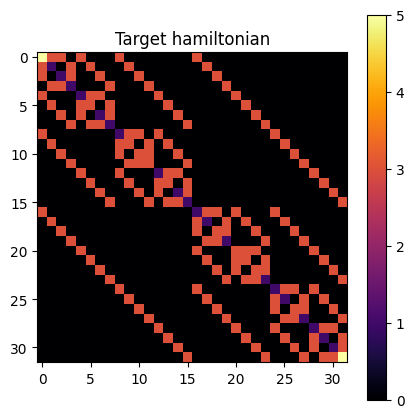

In [5]:
# set the qibo backend (we suggest qibojit if N >= 20)
set_backend("numpy")

# hamiltonian parameters
nqubits = 5
h = 3

# define the hamiltonian
h = hamiltonians.TFIM(nqubits=nqubits, h=h)

# vosualize the matrix
visualize_matrix(h.matrix, title="Target hamiltonian")

#### The generator of the evolution

The model is implemented following the procedure presented in [1], and the first practical step is to define the generator of the iteration $\hat{\mathcal{U}}_{\ell}$, which executes one diagonalization step $$\hat{H}_{\ell} = \hat{\mathcal{U}}_{\ell}^{\dagger} \hat{H} \hat{\mathcal{U}}_{\ell}.$$
In `Qibo`, we define the iteration type through a `DoubleBracketGeneratorType` object, which can be chosen between one of the following:
- `canonical`: the generator of the iteration at step $k+1$ is defined using the commutator between the off diagonal part $\sigma(\hat{H_k})$ and the diagonal part $\Delta(\hat{H}_k)$ of the target evolved hamiltonian:
  $$\hat{\mathcal{U}}_{k+1}=\exp\bigl\{s[\Delta(\hat{H}_k), \sigma(\hat{H}_k)]\bigr\}.$$ 
- `single_commutator`: the evolution follows a similar procedure of the previous point in this list, but any additional matrix $D_k$ can be used to control the evolution at each step:
    $$ \hat{\mathcal{U}}_{k+1}=\exp\bigl\{s[D_k, \hat{H}_k]\bigr\}. $$
- `group_commutator`: the following group commutator is used to compute the evolution:
  $$  \hat{\mathcal{U}}_{k+1}= e^{is\hat{H_k}} e^{isD_k} e^{-is\hat{H_k}} e^{-isD_k}, $$
which approximates the canonical commutator for small $s$.

In order to set one of this evolution generators one can do as follow:

In [6]:
# we have a look inside the DoubleBracketGeneratorType class
for generator in DoubleBracketGeneratorType:
    print(generator)

DoubleBracketGeneratorType.canonical
DoubleBracketGeneratorType.single_commutator
DoubleBracketGeneratorType.group_commutator
DoubleBracketGeneratorType.group_commutator_third_order


In [7]:
# here we set the canonical generator
iterationtype = DoubleBracketGeneratorType.canonical

#### The `DoubleBracketIteration` class

A `DoubleBracketIteration` object can be initialize by calling the `qibo.models.double_braket.DoubleBracketIteration` model and passing the target hamiltonian and the generator type we want to use to perform the evolutionary steps.

In [8]:
dbf = DoubleBracketIteration(hamiltonian=deepcopy(h), mode=iterationtype)

#### `DoubleBracketIteration` features

In [9]:
# on which qibo backend am I running the algorithm?
print(f"Backend: {dbf.backend}")

Backend: numpy


In [10]:
# the initial target hamiltonian is a qibo hamiltonian
# thus the matrix can be accessed typing h.matrix
print(f"Initial form of the target hamiltonian:\n{dbf.h0.matrix}")

Initial form of the target hamiltonian:
[[-5.-0.j -3.-0.j -3.-0.j ... -0.-0.j -0.-0.j -0.-0.j]
 [-3.-0.j -1.-0.j -0.-0.j ... -0.-0.j -0.-0.j -0.-0.j]
 [-3.-0.j -0.-0.j -1.-0.j ... -0.-0.j -0.-0.j -0.-0.j]
 ...
 [-0.-0.j -0.-0.j -0.-0.j ... -1.-0.j -0.-0.j -3.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j ... -0.-0.j -1.-0.j -3.-0.j]
 [-0.-0.j -0.-0.j -0.-0.j ... -3.-0.j -3.-0.j -5.-0.j]]


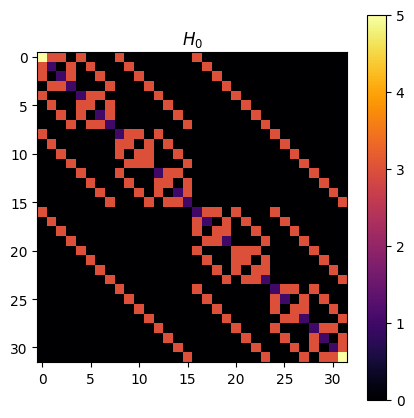

In [11]:
# let's visualize it in a more graphical way
visualize_matrix(dbf.h0.matrix, r"$H_0$")

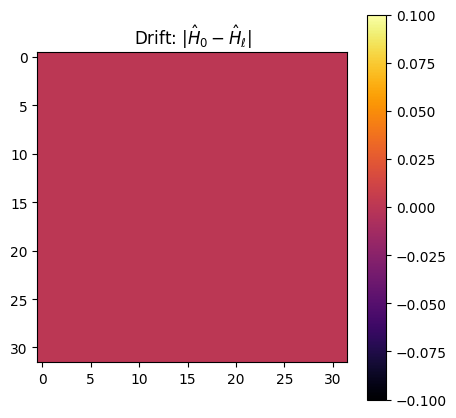

In [12]:
# since we didn't perform yet any evolutionary step they are the same
visualize_drift(dbf.h0.matrix, dbf.h.matrix)

which shows $\hat{H}$ is now identical to $\hat{H}_0$ since no evolution step has been performed yet.

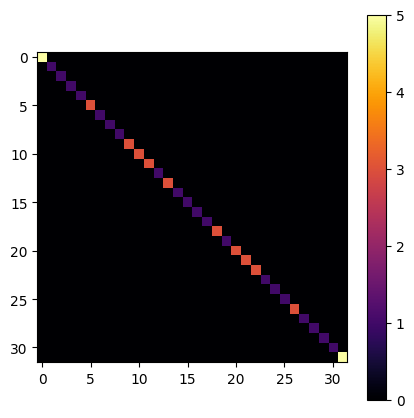

In [13]:
# diagonal part of the H target
visualize_matrix(dbf.diagonal_h_matrix)

The Hilbert-Schmidt norm of a Hamiltonian is defined as:

$\langle A\rangle_{HS}=\sqrt{A^\dagger A}$

In [14]:
# Hilbert-Schmidt norm of the off-diagonal part
# which we want to bring to be close to zero
print(f"HS norm of the off diagonal part of H: {dbf.off_diagonal_norm}")

HS norm of the off diagonal part of H: 37.94733192202055


Finally, the energy fluctuation of the system at step $k$ over a given state $\mu$

$$ \Xi(\mu) = \sqrt{\langle \mu | \hat{H}_k^2 | \mu \rangle - \langle \mu | \hat{H}_k | \mu \rangle^2} $$

can be computed:

In [15]:
# define a quantum state
# for example the ground state of a multi-qubit Z hamiltonian
Z = hamiltonians.Z(nqubits=nqubits)
state = Z.ground_state()

# compute energy fluctuations using current H and given state
dbf.energy_fluctuation(state)

6.708203932499369

#### Call the `DoubleBracketIteration` to perform a DBF iteration

If the DBF object is called, a Double Bracket Iteration iteration is performed. This can be done customizing the iteration by setting the iteration step and the desired `DoubleBracketGeneratorType`. If no generator is provided, the one passed at the initialization time is used (default is `DoubleBracketGeneratorType.canonical`).

In [16]:
# perform one evolution step

# initial value of the off-diagonal norm
print(f"Initial value of the off-diagonal norm: {dbf.off_diagonal_norm}")

dbf(step=0.01, mode=iterationtype)

# after one step
print(f"One step later off-diagonal norm: {dbf.off_diagonal_norm}")

Initial value of the off-diagonal norm: 37.94733192202055
One step later off-diagonal norm: 34.179717587686405


We can check now if something happened by plotting the drift:

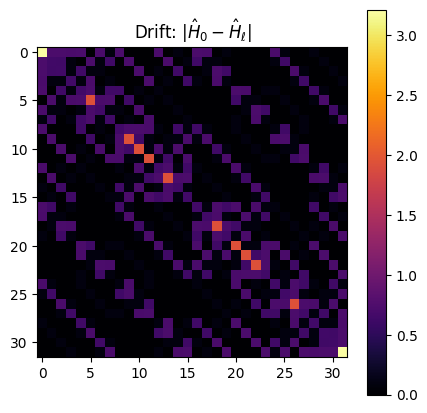

In [17]:
visualize_drift(dbf.h0.matrix, dbf.h.matrix)

The set step can be good, but maybe not the best one. In order to do this choice in a wiser way, we can call the DBF hyperoptimization routine to search for a better initial step. The `dbf.hyperopt_step` method is built on top of the [`hyperopt`](https://hyperopt.github.io/hyperopt/) package. Any algorithm or sampling space provided by the official package can be used. We are going to use the default options (we sample new steps from a uniform space following a _Tree of Parzen estimators algorithm_).

In [18]:
# restart
dbf.h = dbf.h0

# optimization of the step, we allow to search in [1e-5, 1]
step = dbf.choose_step(
    scheduling=DoubleBracketScheduling.hyperopt,
    step_min = 1e-5,
    step_max = 1,
    space = hp.uniform,
    optimizer = tpe,
    max_evals = 1000,
)

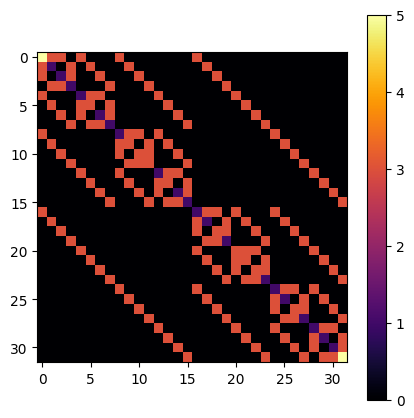

In [19]:
visualize_matrix(dbf.h.matrix)

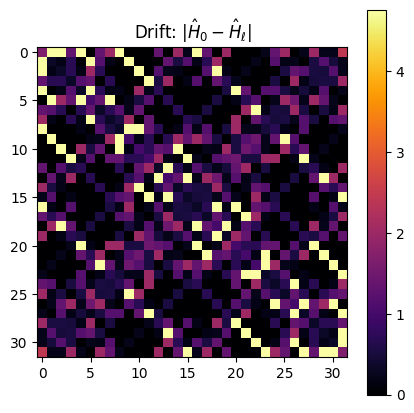

In [20]:
visualize_drift(dbf.h0.matrix, dbf.h.matrix)

#### Let's evolve the model for `NSTEPS`

We know recover the initial hamiltonian, and we perform a sequence of DBF iteration steps, in order to show how this mechanism can lead to a proper diagonalization of the target hamiltonian.

#### Method 1: fixed step

In [21]:
# restart
dbf_1 = DoubleBracketIteration(hamiltonian=deepcopy(h), mode=iterationtype)
off_diagonal_norm_history = [dbf_1.off_diagonal_norm]
histories, labels = [], ["Fixed step"]

# set the number of evolution steps
NSTEPS = 20
step = 0.005

for s in range(NSTEPS):
    dbf_1(step=step)
    off_diagonal_norm_history.append(dbf_1.off_diagonal_norm)

histories.append(off_diagonal_norm_history)

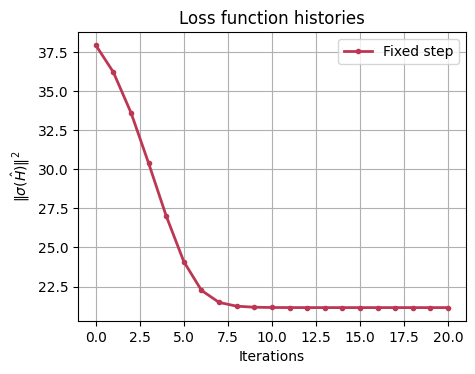

In [22]:
plot_histories(histories, labels)

#### Method 2: optimizing the step

In [23]:
# restart
dbf_2 = DoubleBracketIteration(hamiltonian=deepcopy(h), mode=iterationtype, scheduling=DoubleBracketScheduling.hyperopt)
off_diagonal_norm_history = [dbf_2.off_diagonal_norm]

# set the number of evolution steps
NSTEPS = 20

# optimize first step
step = dbf_2.choose_step(
    step_min = 1e-5,
    step_max = 1,
    space = hp.uniform,
    optimizer = tpe,
    max_evals = 500,
)

for s in range(NSTEPS):
    if s != 0:
        step = dbf_2.choose_step(
            step_min = 1e-5,
            step_max = 1,
            space = hp.uniform,
            optimizer = tpe,
            max_evals = 100,
        )
        print(f"New optimized step at iteration {s}/{NSTEPS}: {step}")
    dbf_2(step=step)
    off_diagonal_norm_history.append(dbf_2.off_diagonal_norm)

histories.append(off_diagonal_norm_history)
labels.append("Optimizing step")

New optimized step at iteration 1/20: 0.012285383759689142
New optimized step at iteration 2/20: 0.008447438941779167
New optimized step at iteration 3/20: 0.007844606075793771
New optimized step at iteration 4/20: 0.005843560327876751
New optimized step at iteration 5/20: 0.010251929595700982
New optimized step at iteration 6/20: 0.005841082475272156
New optimized step at iteration 7/20: 0.004631288000301592
New optimized step at iteration 8/20: 0.006817597467464319
New optimized step at iteration 9/20: 0.010226644173464028
New optimized step at iteration 10/20: 0.007818628910859757
New optimized step at iteration 11/20: 0.005826089136496147
New optimized step at iteration 12/20: 0.016243987144888304
New optimized step at iteration 13/20: 0.0012186965495374139
New optimized step at iteration 14/20: 0.0013670062367486478
New optimized step at iteration 15/20: 0.014667317020784512
New optimized step at iteration 16/20: 0.007361713849428013
New optimized step at iteration 17/20: 0.033871

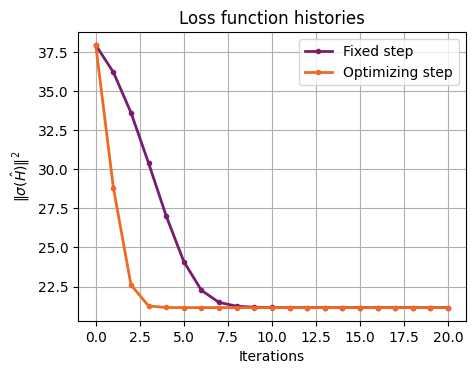

In [24]:
plot_histories(histories, labels)

The hyperoptimization can lead to a faster convergence of the algorithm.

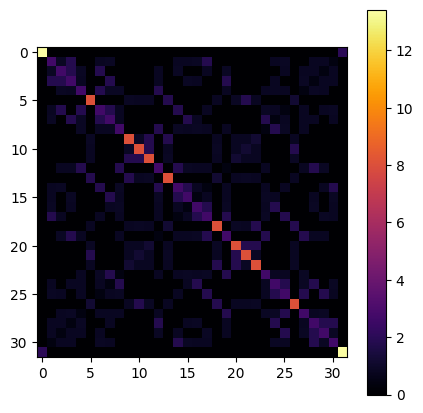

In [25]:
visualize_matrix(dbf_1.h.matrix)

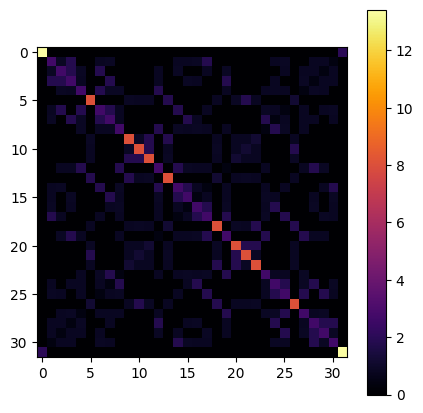

In [26]:
visualize_matrix(dbf_2.h.matrix)